# 1. Import packages and Global parameters setting

In [1]:
import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt

from copy import deepcopy

ITERATIONS = 10
CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'


import subprocess
def get_gpu_usage():
  if torch.cuda.is_available():
    gpu_id = torch.cuda.current_device()  # Get the ID of the current GPU

    # Use `nvidia-smi` command to get GPU utilization
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=utilization.gpu',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')

    # Parse the result to get the utilization percentage
    gpu_util = [int(x) for x in result.strip().split('\n')]
    return gpu_util[gpu_id]

  else:
    return "No dedicated GPU found on this system"

In [2]:
import cvxpy as cp
import numpy as np
import time

x = cp.Variable(3000)

A = np.concatenate([np.ones(1500), 3 * np.ones(1500)])
A = A.reshape(1, 3000)
b = 16

objective = cp.Minimize(cp.norm(x, 1))

g = [x[10*i] + x[10*i+1] + x[10*i+2] + x[10*i+3]+ x[10*i+4]+ x[10*i+5]+ x[10*i+6] + x[10*i+7] + x[10*i+8] + x[10*i+9] - 20 <= 0.0 for i in range(300)]
h = [A @ x - b == 0]

problem = cp.Problem(objective, g + h)

t0 = time.time()
problem.solve(solver='SCS')
print('time: ' + str(time.time()-t0))
print(problem.value)

time: 1.1296443939208984
5.333401742750289


# 2. The 5th NCP

In [3]:
nx = 3000
nu = 300
NY = nx+nu

A = jnp.concatenate([jnp.ones(1500), 3 * jnp.ones(1500)]).reshape(1, 3000)
b = jnp.array([16])
PM = A.T@jnp.linalg.inv(A@A.T)@A

def f(x):
    output = jnp.linalg.norm(x, 1)
    return output

def g(x):
    g = [x[10*i] + x[10*i+1] + x[10*i+2] + x[10*i+3]+ x[10*i+4]+ x[10*i+5]+ x[10*i+6] + x[10*i+7] + x[10*i+8] + x[10*i+9] - 20 for i in range(300)]
    output = jnp.array(g)
    return output

def h(x):
    output = jnp.clip(A@x-b, a_min=-1, a_max=1)

    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    x, u = xu[:nx].reshape((nx,)), xu[nx:].reshape((nu,))
    x = x - (A.T@jnp.linalg.inv(A@A.T))@((A@x-b).reshape((-1, )))
    u = np.clip(u, a_min=0, a_max=None)
    output = np.concatenate([x, u], axis=0)
    return output

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -(jnp.identity(nx) - PM)@dx - A.T@h(x)
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, \
        f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0).all():
        obj = f(x)
    else:
        obj = np.inf
    return obj

In [4]:
"""
xu0 = jnp.ones(NY)
sol = solve_ivp(ODE, [0., 10.], xu0, t_eval=np.arange(0, 10, 0.01), method='BDF')
result = P(sol.y[:, -1])
print(evalutation(result))
print(result)
"""

"\nxu0 = jnp.ones(NY)\nsol = solve_ivp(ODE, [0., 10.], xu0, t_eval=np.arange(0, 10, 0.01), method='BDF')\nresult = P(sol.y[:, -1])\nprint(evalutation(result))\nprint(result)\n"

In [5]:
"""
x, u = result[:nx], result[nx:]
error1 = df(x)+u@dg(x)
error1 = np.max(np.abs((error1)))
error2 = u-np.clip(u+g(x),a_min=0,a_max=None)
error2 = np.max(np.abs((error2)))
print(error1, error2)
"""

'\nx, u = result[:nx], result[nx:]\nerror1 = df(x)+u@dg(x)\nerror1 = np.max(np.abs((error1)))\nerror2 = u-np.clip(u+g(x),a_min=0,a_max=None)\nerror2 = np.max(np.abs((error2)))\nprint(error1, error2)\n'

# 3. The method

In [6]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, 100)
        self.linear2 = nn.Linear(100, NY)

    def forward(self, x):
        t = x
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x

class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if CUDA:
            net = net.cuda()
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss

    def loss_compute(self, t, net, weighting=0.5):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        loss = mse(dy, pdy) # [NBATCH, NY]
        loss = torch.sum(loss, axis=1) # [NBATCH]
        if weighting is not None:
            loss = torch.exp(-weighting*t.detach().reshape((-1, )))*loss # proprity smaller t
        loss = torch.mean(loss, axis=0)
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [7]:
NBATCH = 64 # 512
ITERATIONS = 1000
LR = 0.001

In [8]:
y0 = np.ones(NY)
example_IP1 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init


In [9]:

L_epsilon_IP1, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example_IP1.NN_method() # train

T: 10, Iteration: 0, Loss: 4116.2920,  epsilon_best: 1720.5508, y_T: [0.0337 0.0335 0.5578 ... 0.6559 1.6124 0.5516]
T: 10, Iteration: 100, Loss: 1785.2385,  epsilon_best: 737.3340, y_T: [ 0.3232 -0.0835 -0.1853 ...  0.3654  0.      0.099 ]
T: 10, Iteration: 200, Loss: 3123.2715,  epsilon_best: 370.7354, y_T: [0.1945 0.1347 0.0264 ... 0.0587 0.0323 0.0931]
T: 10, Iteration: 300, Loss: 3103.7656,  epsilon_best: 253.5921, y_T: [ 0.0359  0.0539 -0.0675 ...  0.      0.0045  0.124 ]
T: 10, Iteration: 400, Loss: 2906.7441,  epsilon_best: 247.2399, y_T: [ 0.0713  0.051  -0.0792 ...  0.      0.0104  0.1218]
T: 10, Iteration: 500, Loss: 3090.5063,  epsilon_best: 247.2399, y_T: [ 0.0713  0.051  -0.0792 ...  0.      0.0104  0.1218]
T: 10, Iteration: 600, Loss: 2405.2168,  epsilon_best: 237.6658, y_T: [0.0782 0.1462 0.0191 ... 0.     0.0576 0.0419]
T: 10, Iteration: 700, Loss: 2942.6035,  epsilon_best: 175.1691, y_T: [ 0.0056  0.0594 -0.0253 ...  0.0131  0.0501  0.0232]


KeyboardInterrupt: 

In [10]:
y0 = np.ones(NY) * 3
example_IP2 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon_IP2, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example_IP2.NN_method() # train

T: 10, Iteration: 0, Loss: 151193.3906,  epsilon_best: inf, y_T: [1.6383 2.0097 1.8159 ... 2.7381 2.5388 2.4941]
T: 10, Iteration: 100, Loss: 17833.4238,  epsilon_best: inf, y_T: [1.6383 2.0097 1.8159 ... 2.7381 2.5388 2.4941]
T: 10, Iteration: 200, Loss: 17942.7773,  epsilon_best: inf, y_T: [1.6383 2.0097 1.8159 ... 2.7381 2.5388 2.4941]
T: 10, Iteration: 300, Loss: 15740.7754,  epsilon_best: inf, y_T: [1.6383 2.0097 1.8159 ... 2.7381 2.5388 2.4941]
T: 10, Iteration: 400, Loss: 18783.4102,  epsilon_best: inf, y_T: [1.6383 2.0097 1.8159 ... 2.7381 2.5388 2.4941]
T: 10, Iteration: 500, Loss: 17772.6797,  epsilon_best: inf, y_T: [1.6383 2.0097 1.8159 ... 2.7381 2.5388 2.4941]
T: 10, Iteration: 600, Loss: 18413.2324,  epsilon_best: inf, y_T: [1.6383 2.0097 1.8159 ... 2.7381 2.5388 2.4941]
T: 10, Iteration: 700, Loss: 23825.0352,  epsilon_best: inf, y_T: [1.6383 2.0097 1.8159 ... 2.7381 2.5388 2.4941]
T: 10, Iteration: 800, Loss: 19649.6445,  epsilon_best: inf, y_T: [1.6383 2.0097 1.8159 .

In [11]:
y0 = np.ones(NY) * -1
example_IP3 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon_IP3, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example_IP3.NN_method() # train

T: 10, Iteration: 0, Loss: 191326.2812,  epsilon_best: 1696.5894, y_T: [-0.6965 -0.5504 -1.3197 ...  0.      0.      0.    ]
T: 10, Iteration: 100, Loss: 2080.5676,  epsilon_best: 1665.9153, y_T: [-0.6742 -0.5148 -1.2977 ...  0.      0.      0.    ]
T: 10, Iteration: 200, Loss: 391.5111,  epsilon_best: 1665.9153, y_T: [-0.6742 -0.5148 -1.2977 ...  0.      0.      0.    ]
T: 10, Iteration: 300, Loss: 410.1790,  epsilon_best: 1665.9153, y_T: [-0.6742 -0.5148 -1.2977 ...  0.      0.      0.    ]
T: 10, Iteration: 400, Loss: 435.3368,  epsilon_best: 1665.9153, y_T: [-0.6742 -0.5148 -1.2977 ...  0.      0.      0.    ]
T: 10, Iteration: 500, Loss: 375.6798,  epsilon_best: 1665.9153, y_T: [-0.6742 -0.5148 -1.2977 ...  0.      0.      0.    ]
T: 10, Iteration: 600, Loss: 459.0765,  epsilon_best: 1665.9153, y_T: [-0.6742 -0.5148 -1.2977 ...  0.      0.      0.    ]
T: 10, Iteration: 700, Loss: 396.3231,  epsilon_best: 1665.9153, y_T: [-0.6742 -0.5148 -1.2977 ...  0.      0.      0.    ]
T: 10,

In [12]:
y0 = np.ones(NY) * 2
y0[1::2] = -2 
example_IP4 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon_IP4, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example_IP4.NN_method() # train

T: 10, Iteration: 0, Loss: 14659.2910,  epsilon_best: 6034.9111, y_T: [ 1.1847 -2.2847  2.445  ...  0.      2.4367  0.    ]
T: 10, Iteration: 100, Loss: 1475.4302,  epsilon_best: 6034.9111, y_T: [ 1.1847 -2.2847  2.445  ...  0.      2.4367  0.    ]
T: 10, Iteration: 200, Loss: 1351.9862,  epsilon_best: 6034.9111, y_T: [ 1.1847 -2.2847  2.445  ...  0.      2.4367  0.    ]
T: 10, Iteration: 300, Loss: 1337.8148,  epsilon_best: 6034.9111, y_T: [ 1.1847 -2.2847  2.445  ...  0.      2.4367  0.    ]
T: 10, Iteration: 400, Loss: 1425.4880,  epsilon_best: 6034.9111, y_T: [ 1.1847 -2.2847  2.445  ...  0.      2.4367  0.    ]
T: 10, Iteration: 500, Loss: 1358.2183,  epsilon_best: 6034.9111, y_T: [ 1.1847 -2.2847  2.445  ...  0.      2.4367  0.    ]
T: 10, Iteration: 600, Loss: 1481.2988,  epsilon_best: 6034.9111, y_T: [ 1.1847 -2.2847  2.445  ...  0.      2.4367  0.    ]
T: 10, Iteration: 700, Loss: 1789.9413,  epsilon_best: 6034.9111, y_T: [ 1.1847 -2.2847  2.445  ...  0.      2.4367  0.    ]
T

In [13]:
y0 = np.ones(NY) 
y0[NY//2:] = 3
example_IP5 = NN_NOP(y0, [0, 10], P, ODE, evalutation) # init
L_epsilon_IP5, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example_IP5.NN_method() # train

T: 10, Iteration: 0, Loss: 41780.5859,  epsilon_best: 1589.2483, y_T: [-0.0457 -0.2037  0.6317 ...  1.9098  2.0935  2.2483]
T: 10, Iteration: 100, Loss: 12783.7793,  epsilon_best: 1588.1257, y_T: [-0.0669 -0.2277  0.6012 ...  1.8642  2.0452  2.2049]
T: 10, Iteration: 200, Loss: 10290.6465,  epsilon_best: 1588.1257, y_T: [-0.0669 -0.2277  0.6012 ...  1.8642  2.0452  2.2049]
T: 10, Iteration: 300, Loss: 11632.1152,  epsilon_best: 1588.1257, y_T: [-0.0669 -0.2277  0.6012 ...  1.8642  2.0452  2.2049]
T: 10, Iteration: 400, Loss: 11595.3994,  epsilon_best: 1588.1257, y_T: [-0.0669 -0.2277  0.6012 ...  1.8642  2.0452  2.2049]
T: 10, Iteration: 500, Loss: 10554.3047,  epsilon_best: 1588.1257, y_T: [-0.0669 -0.2277  0.6012 ...  1.8642  2.0452  2.2049]
T: 10, Iteration: 600, Loss: 12341.3750,  epsilon_best: 1588.1257, y_T: [-0.0669 -0.2277  0.6012 ...  1.8642  2.0452  2.2049]
T: 10, Iteration: 700, Loss: 12022.0273,  epsilon_best: 1588.1257, y_T: [-0.0669 -0.2277  0.6012 ...  1.8642  2.0452  2.

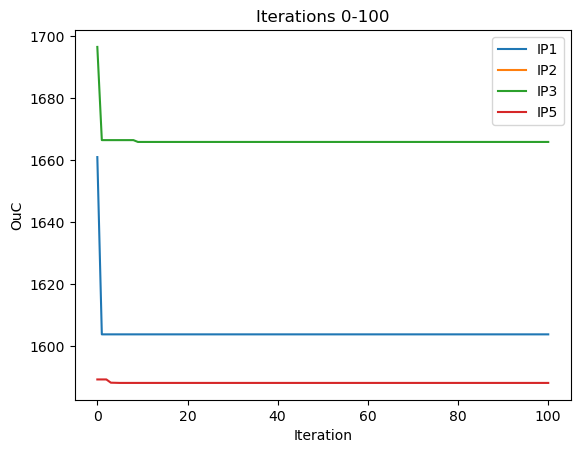

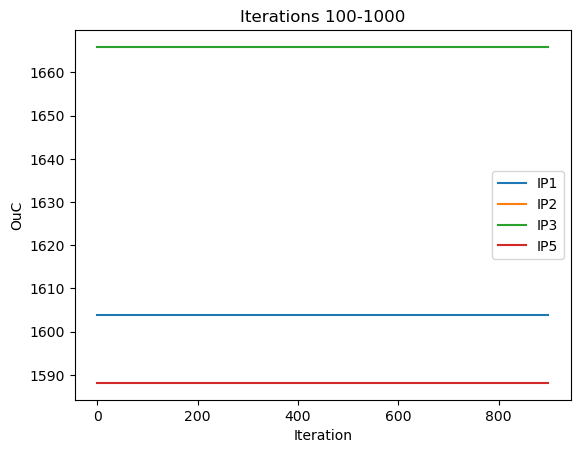

In [15]:
# Create the first plot (iterations 0 to 100)
plt.figure()

plt.plot(L_epsilon_IP1[:101], label='IP1')
plt.plot(L_epsilon_IP2[:101], label='IP2')
plt.plot(L_epsilon_IP3[:101], label='IP3')
#plt.plot(L_epsilon_IP4[:101], label='IP4')
plt.plot(L_epsilon_IP5[:101], label='IP5')

# Add labels, legend, and title
plt.xlabel('Iteration')
plt.ylabel('OuC')
plt.title('Iterations 0-100')
plt.legend()

# Create the second plot (iterations 100 to 1000)
plt.figure() 

# Plot each list, slicing to include elements from 100 to 1000
plt.plot(L_epsilon_IP1[100:], label='IP1')
plt.plot(L_epsilon_IP2[100:], label='IP2')
plt.plot(L_epsilon_IP3[100:], label='IP3')
#plt.plot(L_epsilon_IP4[100:], label='IP4')
plt.plot(L_epsilon_IP5[100:], label='IP5')

# Add labels, legend, and title
plt.xlabel('Iteration')
plt.ylabel('OuC')
plt.title('Iterations 100-1000')
plt.legend()

# Show the plots
plt.show()

In [24]:
t_span = [0, 10]
t_eval = np.linspace(t_span[0], t_span[1], 100)

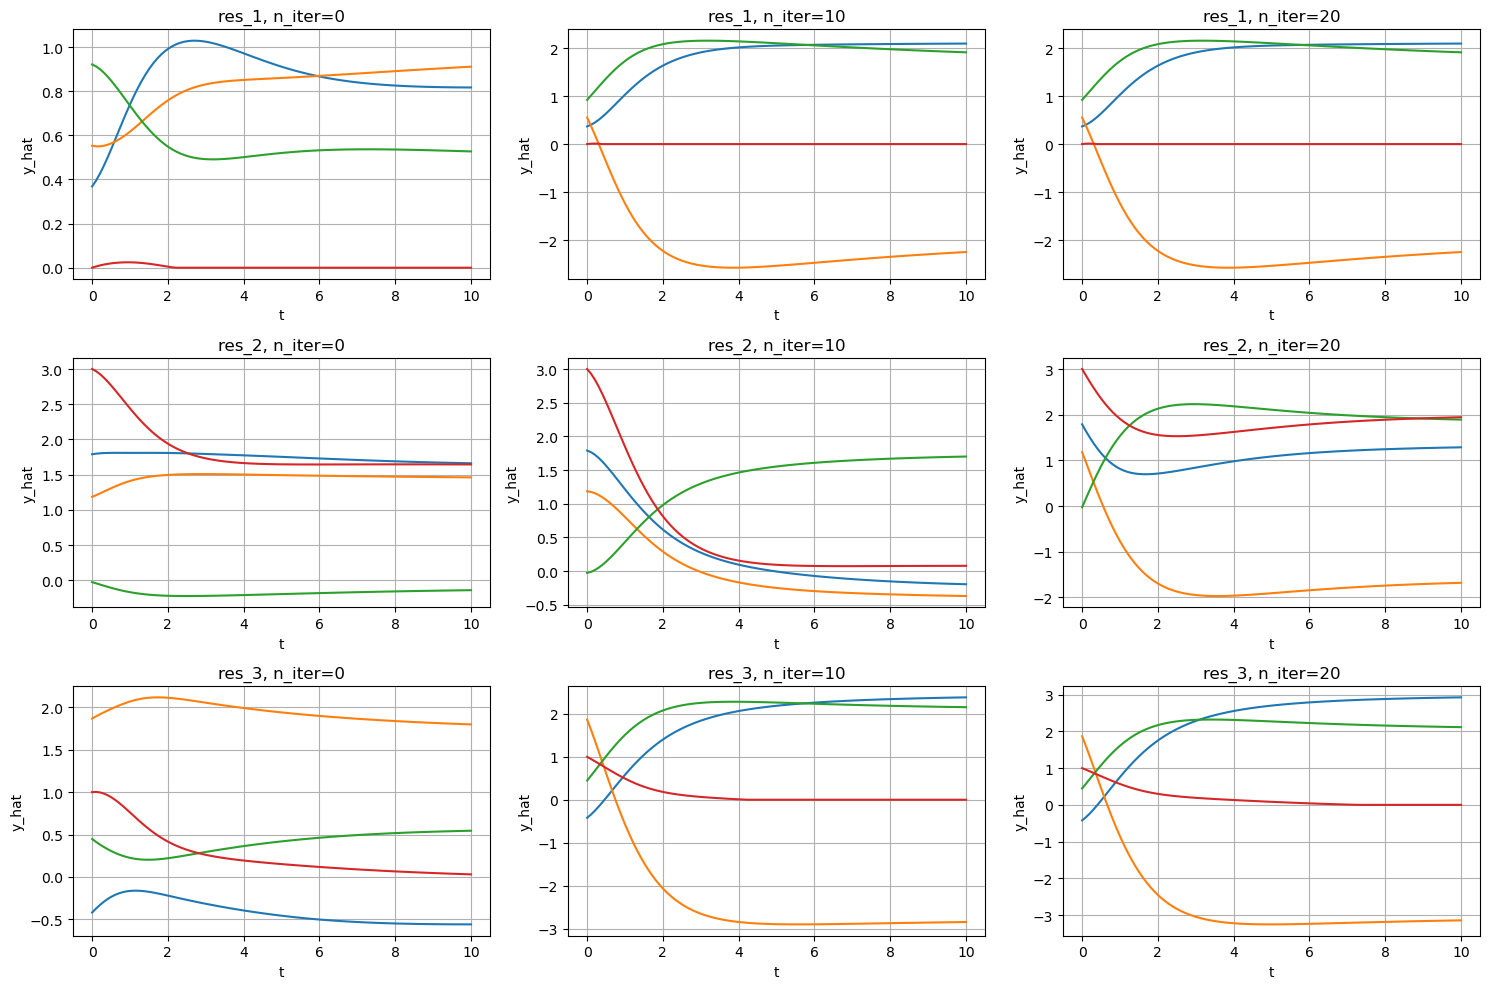

In [28]:


# Create a figure and axes for 9 subplots (3 rows, 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Adjust figsize as needed

# Define the n_iter values to plot
n_iters = [0, 10, 20]

# Plot data for each subplot
for i, res in enumerate([res_1, res_2, res_3]):
    for j, n_iter in enumerate(n_iters):
        row = i 
        col = j

        y_proj = res['L_y_iterations'][n_iter].T

        # Iterate and plot
        for k in range(y_ODE.shape[0]):
            axes[row, col].plot(t_eval, y_proj[k], label=f'y_{k+1}', linestyle='-')  # Adjust label and style

        axes[row, col].set_xlabel('t')
        axes[row, col].set_ylabel('y_hat')
        axes[row, col].set_title(f'res_{i+1}, n_iter={n_iter}')
        axes[row, col].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [33]:

sol = solve_ivp(ODE, [0, 10], y0, method=NUMERICAL_METHOD, t_eval=t_eval)
y_ODE = sol.y

In [34]:
t_torch = torch.tensor(t_eval.reshape((-1, 1)), dtype=torch.float).cuda()

y_nn = net_best(t_torch)
y_nn = y_nn.T.cpu().detach().numpy()

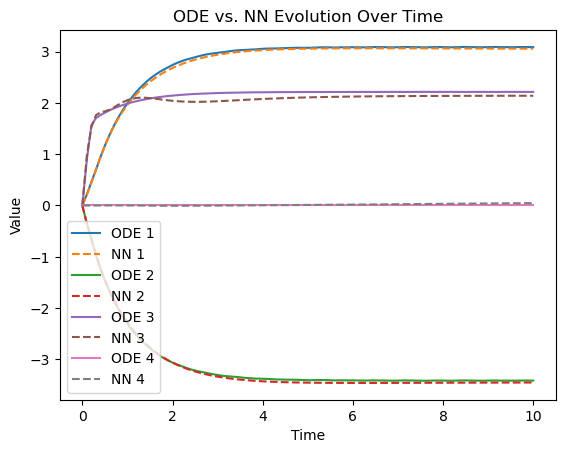

In [35]:
# Create a figure and axes
fig, ax = plt.subplots()

# Iterate and plot
for i in range(y_ODE.shape[0]):
    ax.plot(t_eval, y_ODE[i], label=f'ODE {i+1}')  # Adjust label as needed
    ax.plot(t_eval, y_nn[i], label=f'NN {i+1}', linestyle='--')  # Adjust label and style

# Add labels, legend, and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('ODE vs. NN Evolution Over Time')
ax.legend()

# Display the plot
plt.show()